<a href="https://colab.research.google.com/github/amutharun/RAG/blob/main/02_Advanced_RAG_Retriever.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Retrieval-Augmented Generation (RAG): LangChain Implementation
This Notebook implements an advanced RAG system with the following components
* How to handle **multiple data sources**
* Showcases the power of various **Advanced Retrievers**

In [1]:
!git clone https://github.com/amutharun/RAG.git

Cloning into 'RAG'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (22/22), 5.41 MiB | 13.98 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [2]:
!pip install -r /content/RAG/rag_requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 73.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.8/479.8 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.3/276.3 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

## Imports

In [75]:
import os
import time
import warnings
warnings.filterwarnings("ignore")

from dotenv import load_dotenv
load_dotenv()

True

In [76]:
from RAG.utils import pretty_print_result, pretty_print_docs

## Azure - Model & Embeddings Configuration
Define relevant environment variables in a .env file

In [74]:
# Setting up the env vars

# if directly using open ai api key
# import openai
# openai.api_key = os.getenv("OPENAI_API_KEY")
# openai.api_type = "openai"

# Fetch the Azure Open AI env variables
GPT4_TURBO_DEPLOYMENT_NAME = os.getenv('GPT4_TURBO_DEPLOYMENT_NAME')
API_KEY = os.getenv('API_KEY')
API_BASE = os.getenv('API_BASE')
API_TYPE = os.getenv('API_TYPE')
API_VERSION = os.getenv('API_VERSION')

EMBEDDING_API_KEY = os.getenv('API_KEY')
EMBEDDING_API_BASE = os.getenv('API_BASE')
EMBEDDING_DEPLOYMENT_NAME = os.getenv('EMBEDDING_DEPLOYMENT_NAME')

## Step1: Document Loading
Load 4 documents - 2022 & 2023 Annual Reports of Apple and Microsoft

In [15]:
from langchain.document_loaders import DirectoryLoader, PyPDFLoader

loader = DirectoryLoader('/content/RAG/data/', glob="**/*.pdf", loader_cls = PyPDFLoader, use_multithreading=True)
documents = loader.load()
print(len(documents))

356


## Step2: Document Splitting

In [16]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

def chunkByWord(text):
    return len(text.split(" "))

text_splitter = RecursiveCharacterTextSplitter(chunk_size=700, length_function = chunkByWord, chunk_overlap=50, add_start_index = False)

docs = text_splitter.split_documents(documents)

print(len(docs))

562


## Step3: Vectorstores & Embeddings

In [77]:
from langchain.vectorstores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings

# Direct open ai way
# embeddings = OpenAIEmbeddings()

# Azure open ai way
embeddings = OpenAIEmbeddings(deployment=EMBEDDING_DEPLOYMENT_NAME,
                              openai_api_key=EMBEDDING_API_KEY,
                              openai_api_base=EMBEDDING_API_BASE,
                              openai_api_version=API_VERSION,
                              openai_api_type=API_TYPE,
                              chunk_size=1)

In [78]:
## save to disk
# vectorstore = Chroma.from_documents(documents=docs, embedding=embeddings, persist_directory='vectorstore/annual_reports/')

## load from disk
vectorstore = Chroma(persist_directory='vectorstore/annual_reports/',embedding_function=embeddings)

In [79]:
from langchain.chat_models import AzureChatOpenAI, ChatOpenAI

# Open AI way
# llm = ChatOpenAI(model="gpt-4-0125-preview",temperature=0)

# Azure Open AI way
llm = AzureChatOpenAI(
        openai_api_base=API_BASE,
        openai_api_version=API_VERSION,
        deployment_name=GPT4_TURBO_DEPLOYMENT_NAME,
        openai_api_key=API_KEY,
        openai_api_type=API_TYPE,
        temperature=0
    )

## Step4: Retrieval

### Type1 - LOTR (Merger Retriever) - Handling multiple retrievers
Lord of the Retrievers, also known as MergerRetriever, takes a list of retrievers as input and merges the results of their get_relevant_documents() methods into a single list. The merged results will be a list of documents that are relevant to the query and that have been ranked by the different retrievers.

The MergerRetriever class can be used to improve the accuracy of document retrieval in a number of ways. First, it can combine the results of multiple retrievers, which can help to reduce the risk of bias in the results. Second, it can rank the results of the different retrievers, which can help to ensure that the most relevant documents are returned first.

In [80]:
from langchain.retrievers import MergerRetriever

# Define 2 diff retrievers with 2 diff search type.
retriever_1 = vectorstore.as_retriever(search_type="similarity",
                                                 search_kwargs={"k": 5, "include_metadata": True}
                                                )

retriever_2 = vectorstore.as_retriever(search_type="mmr",
                                                 search_kwargs={"k": 5, "include_metadata": True}
                                                )

lotr = MergerRetriever(retrievers=[retriever_1, retriever_2])

In [81]:
from RAG.utils import *

In [82]:
def pretty_print_result(query, _llm, retriever):
    """
    Custom function to print clean output
    """
    chain = ConversationalRetrievalChain.from_llm(llm=_llm,
                                           combine_docs_chain_kwargs={"prompt": RAG_prompt},
                                          retriever=retriever,
                                           memory=memory,
                                           return_source_documents=True)
    try:
        result = chain({"question": query})
        display(Markdown("Answer: " + result["answer"].replace('$','`$`')))
        print("=============================================================================================================")
        display(Markdown(f"\n{'-.' * 100}\n\n".join([f"Document {i+1}:\n\n" + d.page_content.replace('$','`$`') +"\n\n" + str(d.metadata) for i, d in enumerate(result['source_documents'])])))
    except Exception as e:
        print(e)
        pass
    print("No of documents retrieved" + str(len(result['source_documents'])))
    return


In [83]:
query = "Compare the Revenue trends of Microsoft between the years 2022 and 2023?"
pretty_print_result(query, llm, lotr)

Answer: Between fiscal years 2022 and 2023, Microsoft's revenue increased from `$`198,270 million to `$`211,915 million, marking an increase in revenue. Revenue growth was driven by Intelligent Cloud, Productivity and Business Processes, and More Personal Computing segments. Intelligent Cloud saw a significant increase due to Azure and other cloud services. Productivity and Business Processes benefited from Office 365 Commercial and LinkedIn, while More Personal Computing was bolstered by Windows and Search and news advertising.

Document 1:

Statements (Part II, Item 8 of this Form 10 -K) for further discussion.  
Fiscal Year 2022 Compared with Fiscal Year 2021  
Revenue increased  `$`30.2  billion  or 18% driven by growth across each of our segments. Intelligent Cloud revenue 
increased  driven by Azure and other cloud services. Productivity and Business Processes revenue increased  driven 
by Office 365 Commercial and LinkedIn. More Personal Computing revenue increased  driven by Search and news 
advertising and Windows .  
Cost of revenue increased  `$`10.4 billion  or 20% driven by growth in Microsoft Cloud.  
Gross margin increased  `$`19.8 billion  or 17% driven by growth across each of our segments.  
• Gross margin percentage decreased slightly. Excluding the impact of the fiscal year 2021 change in 
accounting estimate  for the useful lives of our server and network equipment , gross margin percentage 
increased 1 point driven by improvement  in Productivity and Business Processes .

{'page': 40, 'source': '/content/RAG/data/Microsoft_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

Statements (Part II, Item 8 of this Form 10 -K) for further discussion.  
Fiscal Year 2022 Compared with Fiscal Year 2021  
Revenue increased  `$`30.2  billion  or 18% driven by growth across each of our segments. Intelligent Cloud revenue 
increased  driven by Azure and other cloud services. Productivity and Business Processes revenue increased  driven 
by Office 365 Commercial and LinkedIn. More Personal Computing revenue increased  driven by Search and news 
advertising and Windows .  
Cost of revenue increased  `$`10.4 billion  or 20% driven by growth in Microsoft Cloud.  
Gross margin increased  `$`19.8 billion  or 17% driven by growth across each of our segments.  
• Gross margin percentage decreased slightly. Excluding the impact of the fiscal year 2021 change in 
accounting estimate  for the useful lives of our server and network equipment , gross margin percentage 
increased 1 point driven by improvement  in Productivity and Business Processes .

{'page': 40, 'source': '/content/RAG/data/Microsoft_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

respectively.  
Intelligent Cloud  
Revenue increased  `$`12.9  billion or 17%. 
• Server products and cloud services revenue increased `$` 12.6 billion or 19% driven by Azure and other cloud 
services. Azure and other cloud services revenue grew 29% driven by  growth in our consumption -based 
services. Server products revenue decreased 1% . 
• Enterprise Services revenue increased `$` 315 million or 4% driven by growth in Enterprise Support Services, 
offset in part by a decline in Industry Solutions (formerly Microsoft Consulting Services ).

{'page': 41, 'source': '/content/RAG/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 4:

PART II  
Item 8  
91 No sales to an individual customer or country other than the United States accounted for more than 10% of revenue 
for fiscal years 2023 , 2022 , or 2021 . Revenue, classified by the major geographic areas in which our customers were 
located, was as follows:  
 
(In millions)           
     
Year Ended June  30,    2023     2022     2021   
    
United States  (a)   `$` 106,744      `$` 100,218      `$` 83,953    
Other countries      105,171        98,052        84,135    
                 
             
Total    `$` 211,915     `$` 198,270      `$` 168,088    
                       
(a) Includes billings to OEMs and certain multinational organizations because of the nature of these businesses and 
the impracticability of determining the geographic source of the revenue.  
Revenue, classified by significant product and service offerings, was as follows:   
 
(In millions)           
     
Year Ended June  30,    2023     2022     2021   
    
Server products and cloud services     `$` 79,970     `$` 67,350     `$` 52,589    
Office products and cloud services     48,728       44,862       39,872   
Windows      21,507       24,732       22,488    
Gaming     15,466   
    16,230   
    15,370    
LinkedIn    15,145     13,816     10,289    
Search and news advertising      12,208        11,591        9,267    
Enterprise Services    7,722     7,407     6,943   
Devices    5,521     7,306     7,143   
Dynamics    5,437     4,687     3,754   
Other       211       289       373   
              
                
Total    `$` 211,915     `$` 198,270      `$` 168,088

{'page': 91, 'source': '/content/RAG/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 5:

PART II  
Item 7 
 
42 • Office Consumer products and cloud services revenue increased `$` 641 million or 11% driven by Microsoft 
365 Consumer subscription revenue. Microsoft 365 Consumer subscribers grew 15% to 5 9.7 million.  
• LinkedIn revenue increased `$` 3.5 billion or 34% driven by a strong job market in our Talent Solutions 
business and advertising demand in our Marketing Solutions business.  
• Dynamics products and cloud services revenue increased 25% driven by Dynamics 365 growth of 39%.  
Operating income increased  `$`5.3 billion  or 22%. 
• Gross margin increased  `$`7.3 billion  or 17% driven by growth in Office 365 Commercial and LinkedIn. Gross 
margin percentage was relatively unchanged . Excluding the impact of the change in accounting estimate, 
gross margin percentage increased 2 points driven by improvement across all cloud services.  
• Operating expenses increased  `$`2.0 billion  or 11% driven by investments in LinkedIn and cloud engineering.  
Gross margin and operating income both included an unfavorable foreign currency impact of 2%.  
Intelligent Cloud  
Revenue increased  `$`15.2 billion  or 25%.  
• Server products and cloud services revenue increased `$` 14.7 billion or 28% driven by Azure and other cloud 
services. Azure and other cloud services revenue grew 45% driven by  growth in our consumption -based 
services. Server products revenue increased 5% driven by hybrid solutions, including Windows Server and 
SQL Server running in multi -cloud environments . 
• Enterprise Services revenue increased `$` 464 million or 7% driven by growth in Enterprise Support Services.  
Operating income increased  `$`6.6 billion  or 25%.  
• Gross margin increased  `$`9.4 billion  or 22% driven by growth in Azure and other cloud services. Gross 
margin percentage decreased. Excluding the impact of the change in accounting estimate, gross margin 
percentage was relatively unchanged  driven by improvement in Azure and other cloud services, offset in 
part by sales mix shift to Azure and other cloud services.  
• Operating expenses increased  `$`2.8 billion  or 16% driven by investments in Azure and other cloud services.  
Revenue and operating income  included an unfavorable foreign currency impact of 2% and 3%, respectively.  
More Personal Computing  
Revenue increased  `$`5.6 billion  or 10%.  
• Windows revenue increased `$`2. 3 billion or 10% driven by growth in Windows OEM and Windows 
Commercial. Windows OEM  revenue increased 11% driven by continued strength in the commercial PC 
market, which has higher revenue per license. Windows Commercial products and cloud services revenue 
increased 11% driven by demand for Microsoft 365.  
• Search and news advertising  revenue  increased `$` 2.3 billion or 25%. Search and news advertising revenue 
excluding traffic acquisition costs increased 27% driven by higher revenue per search  and search volume . 
• Gaming revenue increased `$` 860 million  or 6% on a strong prior year comparable that benefited from Xbox 
Series X|S launches and stay -at-home scenarios, driven by growth in Xbox hardware and Xbox content and 
services. Xbox hardware revenue increased 16% due to continued demand for Xbox Series X|S.  Xbox 
content and services revenue increased 3% driven by growth in Xbox Game Pass subscriptions and first-
party content , offset in part by a decline in third -party content .  
• Surface  revenue increased `$` 226 million or 3%. 
Operating income increased  `$`1.5 billion  or 8%. 
• Gross margin increased  `$`3.1 billion  or 10% driven by growth in Windows and Search and news advertising. 
Gross margin percentage was relatively unchanged .

{'page': 42, 'source': '/content/RAG/data/Microsoft_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 6:

Products and Services Performance
The following table shows net sales by category for 2023, 2022 and 2021 (dollars in millions):
2023
Change
2022
Change
2021
Net sales by category:
iPhone 
`$`
200,583 
(2)
%
`$`
205,489 
7 
%
`$`
191,973 
Mac 
29,357 
(27)
%
40,177 
14 
%
35,190 
iPad 
28,300 
(3)
%
29,292 
(8)
%
31,862 
Wearables, Home and Accessories 
39,845 
(3)
%
41,241 
7 
%
38,367 
Services 
85,200 
9 
%
78,129 
14 
%
68,425 
Total net sales
`$`
383,285 
(3)
%
`$`
394,328 
8 
%
`$`
365,817 
(1)
Products net sales include amortization of the deferred value of unspeciﬁed software upgrade rights, which are bundled in the sales price of the respective
product.
(2)
Services net sales include amortization of the deferred value of services bundled in the sales price of certain products.
iPhone
iPhone net sales decreased 2% or `$`4.9 billion during 2023 compared to 2022 due to lower net sales of non-Pro iPhone models, partially oﬀset by higher net sales of
Pro iPhone models.
Mac
Mac net sales decreased 27% or `$`10.8 billion during 2023 compared to 2022 due primarily to lower net sales of laptops.
iPad
iPad net sales decreased 3% or `$`1.0 billion during 2023 compared to 2022 due primarily to lower net sales of iPad mini and iPad Air, partially oﬀset by the combined
net sales of iPad 9th and 10th generation.
Wearables, Home and Accessories
Wearables, Home and Accessories net sales decreased 3% or `$`1.4 billion during 2023 compared to 2022 due primarily to lower net sales of Wearables and
Accessories.
Services
Services net sales increased 9% or `$`7.1 billion during 2023 compared to 2022 due to higher net sales across all lines of business.
(1)
(1)
(1)
(1)
(2)
Apple Inc. | 2023 Form 10-K | 22

{'page': 25, 'source': '/content/RAG/data/Apple_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 7:

Reportable Segments  
Fiscal Year 2022 Compared with Fiscal Year 2021   
Productivity and Business Processes   
Revenue increased  `$`9.4 billion  or 18%.  
• Office Commercial products and cloud services revenue increased `$` 4.4 billion or 13%. Office 365 
Commercial revenue grew 18% driven by seat growth of 14%, with continued momentum in small and 
medium business and frontline worker offerings, as well as growth in revenue per user. Office Commercial 
products revenue declined 22% driven by continued customer shift to cloud offerings.

{'page': 41, 'source': '/content/RAG/data/Microsoft_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 8:

PART I  
Item 1  
 
6 Our Future Opportunity  
The case for digital transformation has never been more urgent. Customers  are looking to us to help improve 
productivity and the affordability of their products and services . We continue to develop complete, intelligent solutions 
for our customers that empower people to stay productive and collaborate, while safeguarding businesses and 
simplifying IT management. Our goal is to lead the industry in several distinct areas of te chnology over the long  term, 
which we expect will translate to sustained growth. We are investing significant resources in:  
• Transforming the workplace to deliver new modern, modular business applications , drive deeper insights, 
and improve how people communicate, collaborate, learn, work, play, and interact with one another.  
• Building and running cloud -based services in ways that unleash new experiences and opportunities for 
businesses and individuals.  
• Applying AI to drive insights and act on our customer’s behalf by understanding and interpreting their needs 
using natural methods of communication.  
• Tackling security from all angles with our integrated, end -to-end solutions spanning security, compliance, 
identity, and management, across all clouds and platforms.  
• Inventing new gaming experiences that bring people together around their shared love for games on any 
devices and pushing the boundaries of innovation with console and PC gaming by creating the next wave 
of entertainment.  
• Using Windows to fuel our cloud business, grow our share of the PC market, and drive increased 
engagement  with our services like Microsoft 365 Consumer, Teams, Edge, Bing, Xbox Game Pass, and 
more.  
Our future growth depends on our ability to transcend current product category definitions, business models, and sales 
motions. We have the opportunity to redefine what customers and partners can expect and are working to deliver new 
solutions that reflect  the best of Microsoft.  
Corporate Social Responsibility  
Commitment to Sustainability  
We work to ensure that technology is inclusive, trusted, and increases sustainability. We are accelerating progress 
toward a more sustainable future by reducing our environmental footprint, advancing research, helping our customers 
build sustainable soluti ons, and advocating for policies that benefit the environment. In January 2020, we announced 
a bold commitment and detailed plan to be carbon negative by 2030, and to remove from the environment by 2050 all 
the carbon we have emitted since our founding in 1975. This included a commitment to invest `$`1 billion over four years 
in new technologies and innovative climate solutions. We built on this pledge by adding commitments to be water 
positive by 2030, zero waste by 2030, and to protect ecosystems by develop ing a Planetary Computer. We also help 
our suppliers and customers around the world use Microsoft technology to reduce their own carbon footprint.  
Fiscal year 2021 was a year of both successes and challenges. While we continued to make progress on several of 
our goals, with an overall reduction in our combined Scope 1 and Scope 2 emissions, our Scope 3 emissions increased, 
due in substantial part to significant global datacenter expansions and growth in Xbox sales and usage as a result of 
the COVID -19 pandemic. Despite these Scope 3 increases, we will continue to build the foundations and do the work 
to deliver on our commitments, and help our custome rs and partners achieve theirs . We have  learned the impact of 
our work will not all be felt immediately, and our experience highlights how progress won’t always be linear.  
While fiscal year 2021 presented us with some new learnings, we also made some great progress. A few examples

{'page': 6, 'source': '/content/RAG/data/Microsoft_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 9:

PART II  
Item 7 
 
40 More Personal Computing  
Metrics related to our More Personal Computing segment assess  the performance of key lines of business within this 
segment. These metrics provide strategic product insights which allow us to assess the performance across our 
commercial and consumer businesses. As we have diversity of target audiences and sales motio ns within the Windows 
business, we monitor metrics that are reflective of those varying motions.  
 
Windows OEM revenue growth  
  Revenue from sales of Windows Pro and non -Pro licenses sold through 
the OEM channel  
   Windows Commercial products and cloud 
services revenue growth  
  Revenue from Windows Commercial products and cloud services, 
comprising volume licensing of the Windows operating system, Windows 
cloud services, and other Windows commercial offerings  
   Surface revenue growth    Revenue from Surface devices and accessories  
   Xbox content and services revenue 
growth  
  Revenue from Xbox content and services, comprising first- and third -
party content (including games and in-game content) , Xbox Game Pass 
and other subscriptions, Xbox Cloud Gaming,  third-party disc royalties, 
advertising, and other cloud services  
   Search and news advertising revenue, 
excluding TAC, growth    Revenue from search and news advertising excluding traffic acquisition 
costs (“TAC”) paid to Bing Ads network publishers and news partners  
SUMMARY RESULTS OF OPERATIONS  
 
(In millions,  except  percentages  and per share  amounts)    2022     2021   Percentage  
Change    
     
     
Revenue    `$` 198,270   
`$` 168,088      
  18%   
Gross margin     135,620   
 115,856      
  17%   
Operating income     83,383   
 69,916      
  19%   
Net income    72,738    
 61,271    19%  
Diluted earnings per share     9.65   
 8.05     
  20%   
            Adjusted net income (non -GAAP)    69,447    
 60,651    15%  
Adjusted diluted earnings per share (non -GAAP)    9.21   
 7.97   16%  
 
Adjusted net income and adjusted diluted earnings per share (“EPS”) are non -GAAP financial measures which exclude 
the net  income tax benefit related to transfer of intangible properties in the first quarter of fiscal year 2022 and the net 
income tax benefit related to an India Supreme Court decision on withholding taxes in the third quarter of fiscal year 
2021 . Refer to the Non -GAAP Financial Measures section below for a reconciliation of our financial results reported in 
accordance with GAAP to non -GAAP fi nancial results. See Note 12 – Income Taxes of the Notes to Financial 
Statements (Part II, Item 8 of this Form 10 -K) for further discussion.  
Fiscal Year 2022 Compared with Fiscal Year 2021  
Revenue increased  `$`30.2  billion  or 18% driven by growth across each of our segments. Intelligent Cloud revenue

{'page': 40, 'source': '/content/RAG/data/Microsoft_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 10:

PART I  
Item 1A  
 
23 It is uncertain whether our strategies will attract the users or generate the revenue required to succeed. If we are not 
effective in executing organizational and technical changes to increase efficiency and accelerate innovation, or if we 
fail to generate  sufficient usage of our new products and services, we may not grow revenue in line with the 
infrastructure and development investments described above. This may negatively impact gross margins and operating 
income.  
Some users may engage in fraudulent or abusive activities through our cloud -based services. These include 
unauthorized use of accounts through stolen credentials, use of stolen credit cards or other payment vehicles, failure 
to pay for services accessed, o r other activities that violate our terms of service such as cryptocurrency mining or 
launching cyberattacks. If our efforts to detect such violations or our actions to control these types of fraud and abuse 
are not effective, we may experience adverse imp acts to our revenue or incur reputational damage.  
RISKS RELATING TO THE EVOLUTION OF OUR BUSINESS  
We make significant investments in products and services that may not achieve expected returns.  We will 
continue to make significant investments in research, development, and marketing for existing products, services, and 
technologies, including the Windows operating system, Microsoft 365, Bing, SQL Server, Windows Server, Azure, 
Office 365, Xbox, Li nkedIn, and other products and services. In addition, we are focused on developing new AI platform 
services and incorporating AI into existing products and serv ices. We also invest in the development and acquisition 
of a variety of hardware for productivity, communication, and entertainment, including PCs, tablets, gaming devices, 
and HoloLens. Investments in new technology are speculative. Commercial success depends o n many factors, 
including innovativeness, developer support, and effective distribution and marketing. If customers do not perceive our 
latest offerings as providing significant new functionality or other value, they may reduce their purchases of new  
software and hardware products or upgrades, unfavorably affecting revenue. We may not achieve significant revenue 
from new product, service, and distribution channel investments for several years, if at all. New products and services 
may not be profitable , and even if they are profitable, operating margins for some new products and businesses will 
not be as high as the margins we have experienced historically. We may not get engagement in certain features, like 
Microsoft Edge , Bing, and Bing Chat , that dri ve post -sale monetization opportunities. Our data handling practices 
across our products and services will continue to be under scrutiny. Perceptions of mismanagement, driven by 
regulatory activity or negative public reaction to our practices or product ex periences, could negatively impact product 
and feature adoption, product design, and product quality.  
Developing new technologies is complex. It can require long development and testing periods. Significant delays in 
new releases or significant problems in creating new products or services could adversely affect our revenue.  
Acquisitions, joint ventures, and strategic alliances may have an adverse effect on our business.  We expect to 
continue making acquisitions and entering into joint ventures and strategic alliances as part of our long -term business 
strategy. For example, in March 2021 we completed our acquisition of ZeniMax Media Inc. for `$`8.1 billion, and in March 
2022 we completed our acquisition of Nuance Communications, Inc. for `$`18.8 billion. In January 2022 we announced 
a definitive agreement to acquire Activision Bliz zard, Inc. for `$`68.7 billion.  In January 2023 we announced the third 
phase of our OpenAI strategic partnership. Acquisitions and other transactions and arrangements involve significant 
challenges and risks, including that they do not advance our business strategy, that we get an unsatisfactory return on

{'page': 23, 'source': '/content/RAG/data/Microsoft_2023.pdf'}

No of documents retrieved10


## Type2 - Ensemble Retriever - Handling multiple retrievers
The EnsembleRetriever takes a list of retrievers as input and ensemble the results of their get_relevant_documents() methods and rerank the results based on the Reciprocal Rank Fusion algorithm.

By leveraging the strengths of different algorithms, the EnsembleRetriever can achieve better performance than any single algorithm.

In [84]:
from langchain.retrievers import EnsembleRetriever

# initialize the ensemble retriever
ensemble_retriever = EnsembleRetriever(retrievers=[retriever_1, retriever_2], weights=[0.5, 0.5])

In [37]:
query = "Compare the Revenue trends of Microsoft between the years 2022 and 2023?"
pretty_print_result(query, llm, ensemble_retriever)

Answer: Between fiscal years 2022 and 2023, Microsoft's revenue trends show several key differences:

1. **Revenue Growth**: In fiscal year 2023, Microsoft's revenue increased by `$`13.6 billion or 7%, compared to an 18% increase in fiscal year 2022. This growth in 2023 was driven by Intelligent Cloud and Productivity and Business Processes, offset in part by a decline in More Personal Computing.

2. **Segment Performance**:
   - **Intelligent Cloud**: Continued to drive revenue growth in both fiscal years, with Azure and other cloud services being significant contributors.
   - **Productivity and Business Processes**: Also contributed to revenue growth, driven by Office 365 Commercial and LinkedIn in both years.
   - **More Personal Computing**: Experienced a revenue increase in fiscal year 2022 but saw a decline in fiscal year 2023, influenced by factors like Windows and Devices performance.

3. **Gross Margin**: Increased by `$`10.4 billion or 8% in fiscal year 2023, compared to a 17% increase in fiscal year 2022. The gross margin percentage increased slightly in 2023, whereas it had decreased slightly in 2022 when excluding certain accounting estimate impacts.

4. **Operating Income**: Grew by 6% in fiscal year 2023, compared to a 19% increase in fiscal year 2022.

5. **Net Income**: Saw a slight decrease of 1% in fiscal year 2023, contrasting with a 19% increase in fiscal year 2022.

6. **Effective Tax Rate**: The effective tax rate for fiscal year 2023 was 19%, up from 13% in fiscal year 2022, primarily due to a significant net income tax benefit in the first quarter of fiscal year 2022 related to the transfer of intangible properties and a decrease in tax benefits relating to stock-based compensation.

These differences highlight a year of slower revenue growth in 2023 compared to 2022, with shifts in segment performance and an increase in the effective tax rate impacting net income.

Document 1:

Statements (Part II, Item 8 of this Form 10 -K) for further discussion.  
Fiscal Year 2022 Compared with Fiscal Year 2021  
Revenue increased  `$`30.2  billion  or 18% driven by growth across each of our segments. Intelligent Cloud revenue 
increased  driven by Azure and other cloud services. Productivity and Business Processes revenue increased  driven 
by Office 365 Commercial and LinkedIn. More Personal Computing revenue increased  driven by Search and news 
advertising and Windows .  
Cost of revenue increased  `$`10.4 billion  or 20% driven by growth in Microsoft Cloud.  
Gross margin increased  `$`19.8 billion  or 17% driven by growth across each of our segments.  
• Gross margin percentage decreased slightly. Excluding the impact of the fiscal year 2021 change in 
accounting estimate  for the useful lives of our server and network equipment , gross margin percentage 
increased 1 point driven by improvement  in Productivity and Business Processes .

{'page': 40, 'source': '/content/RAG/data/Microsoft_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

Reportable Segments  
Fiscal Year 2022 Compared with Fiscal Year 2021   
Productivity and Business Processes   
Revenue increased  `$`9.4 billion  or 18%.  
• Office Commercial products and cloud services revenue increased `$` 4.4 billion or 13%. Office 365 
Commercial revenue grew 18% driven by seat growth of 14%, with continued momentum in small and 
medium business and frontline worker offerings, as well as growth in revenue per user. Office Commercial 
products revenue declined 22% driven by continued customer shift to cloud offerings.

{'page': 41, 'source': '/content/RAG/data/Microsoft_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

PART I  
Item 1  
 
6 Our Future Opportunity  
The case for digital transformation has never been more urgent. Customers  are looking to us to help improve 
productivity and the affordability of their products and services . We continue to develop complete, intelligent solutions 
for our customers that empower people to stay productive and collaborate, while safeguarding businesses and 
simplifying IT management. Our goal is to lead the industry in several distinct areas of te chnology over the long  term, 
which we expect will translate to sustained growth. We are investing significant resources in:  
• Transforming the workplace to deliver new modern, modular business applications , drive deeper insights, 
and improve how people communicate, collaborate, learn, work, play, and interact with one another.  
• Building and running cloud -based services in ways that unleash new experiences and opportunities for 
businesses and individuals.  
• Applying AI to drive insights and act on our customer’s behalf by understanding and interpreting their needs 
using natural methods of communication.  
• Tackling security from all angles with our integrated, end -to-end solutions spanning security, compliance, 
identity, and management, across all clouds and platforms.  
• Inventing new gaming experiences that bring people together around their shared love for games on any 
devices and pushing the boundaries of innovation with console and PC gaming by creating the next wave 
of entertainment.  
• Using Windows to fuel our cloud business, grow our share of the PC market, and drive increased 
engagement  with our services like Microsoft 365 Consumer, Teams, Edge, Bing, Xbox Game Pass, and 
more.  
Our future growth depends on our ability to transcend current product category definitions, business models, and sales 
motions. We have the opportunity to redefine what customers and partners can expect and are working to deliver new 
solutions that reflect  the best of Microsoft.  
Corporate Social Responsibility  
Commitment to Sustainability  
We work to ensure that technology is inclusive, trusted, and increases sustainability. We are accelerating progress 
toward a more sustainable future by reducing our environmental footprint, advancing research, helping our customers 
build sustainable soluti ons, and advocating for policies that benefit the environment. In January 2020, we announced 
a bold commitment and detailed plan to be carbon negative by 2030, and to remove from the environment by 2050 all 
the carbon we have emitted since our founding in 1975. This included a commitment to invest `$`1 billion over four years 
in new technologies and innovative climate solutions. We built on this pledge by adding commitments to be water 
positive by 2030, zero waste by 2030, and to protect ecosystems by develop ing a Planetary Computer. We also help 
our suppliers and customers around the world use Microsoft technology to reduce their own carbon footprint.  
Fiscal year 2021 was a year of both successes and challenges. While we continued to make progress on several of 
our goals, with an overall reduction in our combined Scope 1 and Scope 2 emissions, our Scope 3 emissions increased, 
due in substantial part to significant global datacenter expansions and growth in Xbox sales and usage as a result of 
the COVID -19 pandemic. Despite these Scope 3 increases, we will continue to build the foundations and do the work 
to deliver on our commitments, and help our custome rs and partners achieve theirs . We have  learned the impact of 
our work will not all be felt immediately, and our experience highlights how progress won’t always be linear.  
While fiscal year 2021 presented us with some new learnings, we also made some great progress. A few examples

{'page': 6, 'source': '/content/RAG/data/Microsoft_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 4:

PART II  
Item 7 
 
44 Fiscal Year 2023 Compared with Fiscal Year 2022  
Interest and dividends income increased due to higher yields, offset in part by lower portfolio balances. Interest expense 
decreased due to a decrease in  outstanding long -term debt due to debt maturities. Net recognized gains on 
investments decreased due to lower gains on equity securities and higher losses on fixed income securities. Net losses 
on derivatives increased due to losses related to managing st rategic investments.  
INCOME TAXES  
Effective Tax Rate  
Our effective tax rate for fiscal years 2023  and 2022  was 19% and 1 3%, respectively . The increase in our effective tax 
rate was primarily due to a `$`3.3 billion net income tax benefit in the first quarter of fiscal year 2022 related to the trans fer 
of intangible properties and a decrease in tax benefits relating to stock -based compensation.  
In the first quarter of fiscal year 2022, we transferred certain intangible properties from our Puerto Rico subsidiary to 
the U.S. The transfer of intangible properties resulted in a `$`3.3 billion net income tax benefit in the first quarter of fisc al 
year 2 022, as the value of future U.S. tax deductions exceeded the current tax liability from the U.S. global intangible 
low-taxed income tax.  
Our effective tax rate was lower than the U.S. federal statutory rate, primarily due to earnings taxed at lower rates in 
foreign jurisdictions resulting from producing and distributing our products and services through our foreign regional 
operations center in Ireland.  
The mix of income before income taxes between the U.S. and foreign countries impacted our effective tax rate as a 
result of the geographic distribution of, and customer demand for, our products and services. In fiscal year 2023 , our 
U.S. income before income taxes was `$` 52.9 billion and our foreign income before income taxes was `$` 36.4 billion. In 
fiscal year 2022, our U.S. income before income taxes was `$`47.8 billion and our foreign income before income taxes 
was `$`35.9 billion.  
Uncertain Tax Positions  
We settled a portion of the Internal Revenue Service (“IRS”) audit for tax years 2004 to 2006 in fiscal year 2011. In 
February 2012, the IRS withdrew its 2011 Revenue Agents Report related to unresolved issues for tax years 2004 to 
2006 and reopened the audit  phase of the examination. We also settled a portion of the IRS audit for tax years 2007 
to 2009 in fiscal year 2016, and a portion of the IRS audit for tax years 2010 to 2013 in fiscal year 2018. In the second 
quarter of fiscal year 2021, we settled an  additional portion of the IRS audits for tax years 2004 to 2013 and made a 
payment of `$`1.7 billion, including tax and interest. We remain under audit for tax years 2004 to 2017.  
As of  June 30, 2023 , the primary unresolved issues for the  IRS audits relate  to transfer pricing, which could have a 
material impact in our consolidated financial statements when the matters are resolved. We believe our allowances for 
income tax contingencies are adequate . We have not received a proposed assessment for the unresolved key transfer 
pricing issues. We do not expect a final resolution of these issues in the next 12 months.  Based on the information 
currently available, we do not anticipate a significant increase or decrease to our tax contingencies for these issues 
within the next 12 months.  
We are subject to income tax in many jurisdictions outside the U.S. Our operations in certain jurisdictions remain

{'page': 44, 'source': '/content/RAG/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 5:

PART II  
Item 7 
 
40 More Personal Computing  
Metrics related to our More Personal Computing segment assess  the performance of key lines of business within this 
segment. These metrics provide strategic product insights which allow us to assess the performance across our 
commercial and consumer businesses. As we have diversity of target audiences and sales motio ns within the Windows 
business, we monitor metrics that are reflective of those varying motions.  
 
Windows OEM revenue growth  
  Revenue from sales of Windows Pro and non -Pro licenses sold through 
the OEM channel  
   Windows Commercial products and cloud 
services revenue growth  
  Revenue from Windows Commercial products and cloud services, 
comprising volume licensing of the Windows operating system, Windows 
cloud services, and other Windows commercial offerings  
   Surface revenue growth    Revenue from Surface devices and accessories  
   Xbox content and services revenue 
growth  
  Revenue from Xbox content and services, comprising first- and third -
party content (including games and in-game content) , Xbox Game Pass 
and other subscriptions, Xbox Cloud Gaming,  third-party disc royalties, 
advertising, and other cloud services  
   Search and news advertising revenue, 
excluding TAC, growth    Revenue from search and news advertising excluding traffic acquisition 
costs (“TAC”) paid to Bing Ads network publishers and news partners  
SUMMARY RESULTS OF OPERATIONS  
 
(In millions,  except  percentages  and per share  amounts)    2022     2021   Percentage  
Change    
     
     
Revenue    `$` 198,270   
`$` 168,088      
  18%   
Gross margin     135,620   
 115,856      
  17%   
Operating income     83,383   
 69,916      
  19%   
Net income    72,738    
 61,271    19%  
Diluted earnings per share     9.65   
 8.05     
  20%   
            Adjusted net income (non -GAAP)    69,447    
 60,651    15%  
Adjusted diluted earnings per share (non -GAAP)    9.21   
 7.97   16%  
 
Adjusted net income and adjusted diluted earnings per share (“EPS”) are non -GAAP financial measures which exclude 
the net  income tax benefit related to transfer of intangible properties in the first quarter of fiscal year 2022 and the net 
income tax benefit related to an India Supreme Court decision on withholding taxes in the third quarter of fiscal year 
2021 . Refer to the Non -GAAP Financial Measures section below for a reconciliation of our financial results reported in 
accordance with GAAP to non -GAAP fi nancial results. See Note 12 – Income Taxes of the Notes to Financial 
Statements (Part II, Item 8 of this Form 10 -K) for further discussion.  
Fiscal Year 2022 Compared with Fiscal Year 2021  
Revenue increased  `$`30.2  billion  or 18% driven by growth across each of our segments. Intelligent Cloud revenue

{'page': 40, 'source': '/content/RAG/data/Microsoft_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 6:

PART II  
Item 7 
 
43 Sales and Marketing  
 
(In millions, except percentages)    2023     2022       
Percentage  
Change    
  
  
Sales and marketing    `$` 22,759     `$` 21,825      4%   
As a percent of revenue      11%       11%     0ppt   
  
Sales and marketing expenses include payroll, employee benefits, stock -based compensation expense, and other 
headcount -related expenses associated with sales and marketing personnel, and the costs of advertising, promotions, 
trade shows, seminars, and other programs.  
Fiscal Year 2023 Compared with Fiscal Year 2022  
Sales and marketing expenses increased  `$`934 million  or 4% driven by 3 points of growth from the Nuance and Xandr 
acquisitions and investments in commercial sales , offset in part by a decline in Windows advertising . Sales and 
marketing included a favorable foreign currency impact of 2%. 
General and Administrative  
 
(In millions, except percentages)    2023     2022   Percentage  
Change     
     
         
General and administrative    `$` 7,575     `$` 5,900   28%   
As a percent of revenue      4%       3%  1ppt   
     
General and administrative expenses include payroll, employee benefits, stock -based compensation expense, 
employee severance expense incurred as part of a corporate program, and other headcount -related expenses 
associated with finance, legal, facilities, certain human resources and other administrative personnel, certain taxes, 
and legal and other administrative fees.  
Fiscal Year 2023 Compared with Fiscal Year 2022  
General and administrative expenses increased  `$`1.7 billion  or 28% driven by employee severance expenses  and a 
charge related to a non -public preliminary draft decision provided by the Irish Data Protection Commission . General 
and administrative included a favorable foreign currency impact of 2%.  
OTHER INCOME (EXPENSE), NET  
The components of other income (expense), net were as follows:   
 
(In millions)             
  
    
Year Ended June  30,      2023       2022  
    
Interest and dividends income    `$` 2,994  
  `$` 2,094   
Interest expense      (1,968  )     (2,063  ) 
Net recognized gains on investments      260  
    461  
Net losses on derivatives      (456 )     (52 ) 
Net gains (losses) on foreign currency remeasurements      181      (75 ) 
Other, net      (223 )     (32 ) 
      
         
Total    `$` 788     `$` 333

{'page': 43, 'source': '/content/RAG/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 7:

PART II  
Item 7 
 
41 SEGMENT RESULTS OF OPERATIONS  
  
(In millions, except percentages)    2023     2022     Percentage  
Change    
  
  
Revenue                         
     
Productivity and Business Processes   `$` 69,274    `$` 63,364    9%  
Intelligent Cloud    87,907    74,965    17%  
More Personal Computing    54,734      59,941     (9)%  
         
                
Total    `$` 211,915     `$` 198,270      7%   
            
     
Operating Income             
            
Productivity and Business Processes   `$` 34,189   `$` 29,690   15%  
Intelligent Cloud    37,884    33,203   14%  
More Personal Computing    16,450     20,490   (20)%  
         
                
Total   `$` 88,523   `$` 83,383    6%  
            
Reportable Segments  
Fiscal Year 2023  Compared with Fiscal Year 2022   
Productivity and Business Processes  
Revenue increased  `$`5.9 billion or 9%.  
• Office Commercial products and cloud services revenue increased `$` 3.7 billion or 10%. Office 365 
Commercial revenue grew 13% with seat growth of 11%, driven by small and medium business and frontline 
worker offerings, as well as growth in revenue per user. Office Commercial products revenue declined 21% 
driven by continued customer shift to cloud offerings.  
• Office Consumer products and cloud services revenue increased `$` 140 million or 2%. Microsoft 365 
Consumer subscribers grew 12% to 67.0 million.   
• LinkedIn revenue increased `$`1. 3 billion or 10% driven by Talent Solutions.  
• Dynamics products and cloud services revenue increased `$`750 million or 16% driven by Dynamics 365 
growth of 24%. 
Operating income increased  `$`4.5 billion or 15%.  
• Gross margin increased  `$`5.8 billion or 12% driven by growth in Office 365 Commercial  and LinkedIn , as 
well as the change in accounting estimate. Gross margin percentage increased. Excluding the impact of the 
change in accounting estimate, gross margin percentage increased slightly  driven by improvement in Office 
365 Commercial, offset in part by sales mix shift to cloud offerings.  
• Operating expenses increased  `$`1.3 billion or 7% driven by investment in LinkedIn and employee severance 
expenses.  
Revenue, gross margin, and operating income included an unfavorable foreign currency impact of 5%, 5%, and 8%, 
respectively.  
Intelligent Cloud  
Revenue increased  `$`12.9  billion or 17%. 
• Server products and cloud services revenue increased `$` 12.6 billion or 19% driven by Azure and other cloud

{'page': 41, 'source': '/content/RAG/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 8:

Products and Services Performance
The following table shows net sales by category for 2023, 2022 and 2021 (dollars in millions):
2023
Change
2022
Change
2021
Net sales by category:
iPhone 
`$`
200,583 
(2)
%
`$`
205,489 
7 
%
`$`
191,973 
Mac 
29,357 
(27)
%
40,177 
14 
%
35,190 
iPad 
28,300 
(3)
%
29,292 
(8)
%
31,862 
Wearables, Home and Accessories 
39,845 
(3)
%
41,241 
7 
%
38,367 
Services 
85,200 
9 
%
78,129 
14 
%
68,425 
Total net sales
`$`
383,285 
(3)
%
`$`
394,328 
8 
%
`$`
365,817 
(1)
Products net sales include amortization of the deferred value of unspeciﬁed software upgrade rights, which are bundled in the sales price of the respective
product.
(2)
Services net sales include amortization of the deferred value of services bundled in the sales price of certain products.
iPhone
iPhone net sales decreased 2% or `$`4.9 billion during 2023 compared to 2022 due to lower net sales of non-Pro iPhone models, partially oﬀset by higher net sales of
Pro iPhone models.
Mac
Mac net sales decreased 27% or `$`10.8 billion during 2023 compared to 2022 due primarily to lower net sales of laptops.
iPad
iPad net sales decreased 3% or `$`1.0 billion during 2023 compared to 2022 due primarily to lower net sales of iPad mini and iPad Air, partially oﬀset by the combined
net sales of iPad 9th and 10th generation.
Wearables, Home and Accessories
Wearables, Home and Accessories net sales decreased 3% or `$`1.4 billion during 2023 compared to 2022 due primarily to lower net sales of Wearables and
Accessories.
Services
Services net sales increased 9% or `$`7.1 billion during 2023 compared to 2022 due to higher net sales across all lines of business.
(1)
(1)
(1)
(1)
(2)
Apple Inc. | 2023 Form 10-K | 22

{'page': 25, 'source': '/content/RAG/data/Apple_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 9:

PART II  
Item 7 
 
40 SUMMARY RESULTS OF OPERATIONS  
 
(In millions,  except  percentages  and per share  amounts)    2023     2022   Percentage  
Change    
     
     
Revenue    `$` 211,915   
`$` 198,270      
  7%   
Gross margin     146,052   
 135,620      
  8%   
Operating income     88,523   
 83,383      
  6%   
Net income    72,361    
 72,738    (1)%   
Diluted earnings per share     9.68   
 9.65     
  0%   
            Adjusted gross margin (non -GAAP)    146,204   
 135,620    8%  
Adjusted operating income (non -GAAP)    89,694   
 83,383    8%  
Adjusted net income (non -GAAP)    73,307    
 69,447    6%  
Adjusted diluted earnings per share (non -GAAP)    9.81   
 9.21   7%  
 
Adjusted gross margin, operating income, net income, and diluted earnings per share (“EPS”) are non -GAAP financial 
measures. Current year non -GAAP financial measures exclude the impact of the Q2 charge,  which  includes  employee 
severance expenses, impairment charges resulting from changes to our hardware portfolio, and costs related to lease 
consolidation activities. Prior year non -GAAP financial measures  exclude the net  income tax benefit related to transfer 
of intangible properties in the first quarter of fiscal year 2022 . Refer to Note 12 – Income Taxes of the Notes to Financial 
Statements (Part II, Item 8 of this For m 10 -K) for further discussion. Refer to the Non -GAAP Financial Measures section 
below for a reconciliation of our financial results reported in accordance with GAAP to non -GAAP financial results.  
Fiscal Year 2023  Compared with Fiscal Year 2022  
Revenue increased  `$`13.6  billion or 7% driven by growth in Intelligent Cloud and Productivity and Business Processes, 
offset in part by a decline in More Personal Computing. Intelligent Cloud revenue increased  driven by Azure and other 
cloud services. Productivity and Business Processes revenue increased  driven by Office 365 Commercial and 
LinkedIn. More Personal Computing revenue decreased  driven by Windows and Devices . 
Cost of revenue increased  `$`3.2 billion or 5% driven by growth in Microsoft Cloud, offset in part by the change in 
accounting estimate.  
Gross margin increased  `$`10.4  billion or  8% driven by growth in Intelligent Cloud and Productivity and Business 
Processes and the change in accounting estimate, offset in part by a decline in More Personal Computing.  
• Gross margin percentage increased  slightly . Excluding the impact of the change in accounting estimate, 
gross margin percentage decreased 1 point driven by declines in Intelligent Cloud and More Personal 
Computing, offset in part by sales mix shift between our segments . 
• Microsoft Cloud gross margin percentage increased 2 points to 72%. Excluding the impact of the change in 
accounting estimate, Microsoft Cloud gross margin percentage decreased slightly  driven by a decline in

{'page': 40, 'source': '/content/RAG/data/Microsoft_2023.pdf'}

No of documents retrieved9


## Type3 - Contextual Compression

The idea is simple: instead of immediately returning retrieved documents as-is, you can compress them using the context of the given query, so that only the relevant information is returned. “Compressing” here refers to both compressing the contents of an individual document and filtering out documents wholesale.

To use the Contextual Compression Retriever, you’ll need: - a base retriever - a Document Compressor. Here we use "lotr" as base retriever and let's look at different compressors below.

![image.png](attachment:c9d4d9b7-8088-462d-8cb0-6c97632bffbf.png)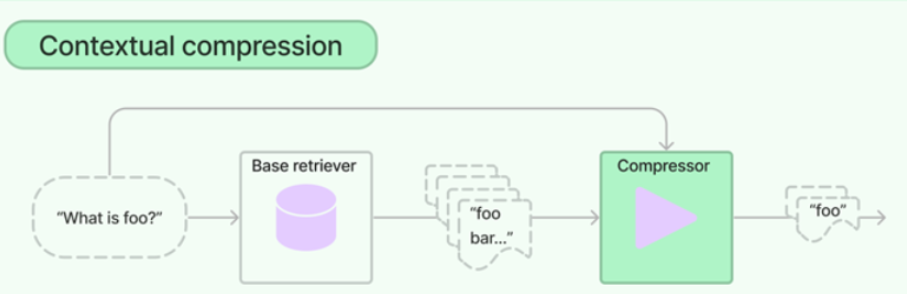

In [38]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import DocumentCompressorPipeline

**LLMChainExtractor:** iterate over the initially returned documents and extract from each only the content that is relevant to the query.

In [39]:
from langchain.retrievers.document_compressors import LLMChainExtractor

compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(base_compressor=compressor,
                                                       base_retriever=lotr)

compressed_docs = compression_retriever.get_relevant_documents("Compare the Revenue trends of Microsoft between the years 2022 and 2023?")
print("No of documents retrieved after compression: " + str(len(compressed_docs)))
pretty_print_docs(compressed_docs)

No of documents retrieved after compression: 6
Document 1:

Fiscal Year 2022 Compared with Fiscal Year 2021  
Revenue increased  $30.2  billion  or 18% driven by growth across each of our segments.
----------------------------------------------------------------------------------------------------
Document 2:

Fiscal Year 2022 Compared with Fiscal Year 2021  
Revenue increased  $30.2  billion  or 18% driven by growth across each of our segments.
----------------------------------------------------------------------------------------------------
Document 3:

```
Revenue    $ 198,270   
$ 168,088      
  18%   
```
----------------------------------------------------------------------------------------------------
Document 4:

Year Ended June  30,    2023     2022     2021   
    
United States  (a)   $ 106,744      $ 100,218      $ 83,953    
Other countries      105,171        98,052        84,135    
                 
             
Total    $ 211,915     $ 198,270      $ 168,088
-----

**LLMChainFilter:** slightly simpler but more robust compressor that uses an LLM chain to decide which of the initially retrieved documents to filter out and which ones to return, without manipulating the document contents.

In [ ]:
from langchain.retrievers.document_compressors import LLMChainFilter

_filter = LLMChainFilter.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(base_compressor=_filter,
                                                       base_retriever=lotr)
compressed_docs = compression_retriever.get_relevant_documents("Compare the Revenue trends of Microsoft between the years 2022 and 2023?")
print("No of documents retrieved after compression: " + str(len(compressed_docs)))
pretty_print_docs(compressed_docs)

**EmbeddingsFilter:** Making an extra LLM call over each retrieved document is expensive and slow. The EmbeddingsFilter provides a cheaper and faster option by embedding the documents and query and only returning those documents which have sufficiently similar embeddings to the query.

In [61]:
from langchain.retrievers.document_compressors import EmbeddingsFilter

embeddings_filter = EmbeddingsFilter(embeddings=embeddings, similarity_threshold=0.83) # change to 0.8 to see the reduction in the num of docs retrieved
compression_retriever = ContextualCompressionRetriever(base_compressor=embeddings_filter,
                                                       base_retriever=lotr)
compressed_docs = compression_retriever.get_relevant_documents("Compare the 2023 Revenue of Microsoft and Apple?")
print("No of documents retrieved after compression: " + str(len(compressed_docs)))
pretty_print_docs(compressed_docs)

No of documents retrieved after compression: 7
Document 1:

Products and Services Performance
The following table shows net sales by category for 2023, 2022 and 2021 (dollars in millions):
2023
Change
2022
Change
2021
Net sales by category:
iPhone 
$
200,583 
(2)
%
$
205,489 
7 
%
$
191,973 
Mac 
29,357 
(27)
%
40,177 
14 
%
35,190 
iPad 
28,300 
(3)
%
29,292 
(8)
%
31,862 
Wearables, Home and Accessories 
39,845 
(3)
%
41,241 
7 
%
38,367 
Services 
85,200 
9 
%
78,129 
14 
%
68,425 
Total net sales
$
383,285 
(3)
%
$
394,328 
8 
%
$
365,817 
(1)
Products net sales include amortization of the deferred value of unspeciﬁed software upgrade rights, which are bundled in the sales price of the respective
product.
(2)
Services net sales include amortization of the deferred value of services bundled in the sales price of certain products.
iPhone
iPhone net sales decreased 2% or $4.9 billion during 2023 compared to 2022 due to lower net sales of non-Pro iPhone models, partially oﬀset by highe

**EmbeddingsRedundantFilter:** Removes redundant documents from the initial returned documents

In [63]:
from langchain.document_transformers  import EmbeddingsRedundantFilter

_filter = EmbeddingsRedundantFilter(embeddings=embeddings,similarity_threshold=0.83)
pipeline = DocumentCompressorPipeline(transformers=[_filter])
compression_retriever = ContextualCompressionRetriever(base_compressor=pipeline,
                                                       base_retriever=lotr)
query = "Compare the 2023 Revenue of Microsoft and Apple"
# print("No of documents retrieved after removing redundant documents: " + str(len(compressed_docs)))
pretty_print_result(query, llm, compression_retriever)

Answer: The 2023 revenue figures are `$`211.915 billion for Apple and `$`111.6 billion for Microsoft.

Document 1:

Products and Services Performance
The following table shows net sales by category for 2022, 2021 and 2020 (dollars in millions):
2022
Change
2021
Change
2020
Net sales by category:
iPhone
`$`
205,489 
7 
%
`$`
191,973 
39 
%
`$`
137,781 
Mac 
40,177 
14 
%
35,190 
23 
%
28,622 
iPad
29,292 
(8)
%
31,862 
34 
%
23,724 
Wearables, Home and Accessories 
41,241 
7 
%
38,367 
25 
%
30,620 
Services 
78,129 
14 
%
68,425 
27 
%
53,768 
Total net sales
`$`
394,328 
8 
%
`$`
365,817 
33 
%
`$`
274,515 
(1)
Products net sales include amortization of the deferred value of unspeciﬁed software upgrade rights, which are bundled in the sales price of the respective
product.
(2)
Wearables, Home and Accessories net sales include sales of AirPods, Apple TV, Apple Watch, Beats products, HomePod mini and accessories.
(3)
Services net sales include sales from the Company’s advertising, AppleCare, cloud, digital content, payment and other services. Services net sales also include
amortization of the deferred value of services bundled in the sales price of certain products.
iPhone
iPhone net sales increased during 2022 compared to 2021 due primarily to higher net sales from the Company’s new iPhone models released since the beginning of
the fourth quarter of 2021.
Mac
Mac net sales increased during 2022 compared to 2021 due primarily to higher net sales of laptops.
iPad
iPad net sales decreased during 2022 compared to 2021 due primarily to lower net sales of iPad Pro.
Wearables, Home and Accessories
Wearables, Home and Accessories net sales increased during 2022 compared to 2021 due primarily to higher net sales of Apple Watch and AirPods.
Services
Services net sales increased during 2022 compared to 2021 due primarily to higher net sales from advertising, cloud services and the App Store.
 (1)
(1)
 (1)
(1)(2)
(3)
Apple Inc. | 2022 Form 10-K | 21

{'page': 24, 'source': '/content/RAG/data/Apple_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

Total    `$` 211,915     `$` 198,270      `$` 168,088    
                       
Our Microsoft Cloud  revenue, which includes Azure and other cloud services, Office 365 Commercial, the commercial 
portion of LinkedIn, Dynamics 365, and other commercial cloud properties, was `$` 111.6 billion, `$` 91.4 billion , and `$` 69.1 
billion in fiscal years 2023 , 2022 , and 2021 , respectively. These amounts are primarily included in Server products and 
cloud services, Office products and cloud services, LinkedIn , and Dynamics  in the table above.  
Assets are not allocated to segments for internal reporting presentations. A portion of amortization and depreciation is 
included with various other costs in an overhead allocation to each segment. It is impracticable for us to separately 
identify the amount of amortization and depreciation by segment that is inclu ded in the measure of segment profit or 
loss. 
Long -lived assets, excluding financial instruments and tax assets, classified by the location of the controlling statutory 
company and with countries over 10% of the total shown separately, were as follows:  
 
(In millions)        
   
     
June  30,    2023     2022     2021   
    
United States    `$` 114,380      `$` 106,430      `$` 76,153    
Ireland      16,359        15,505        13,303    
Other countries      56,50 0       44,433        38,858                                  
Total    `$` 187,2 39     `$` 166,368      `$`  128,314

{'page': 91, 'source': '/content/RAG/data/Microsoft_2023.pdf'}

No of documents retrieved2


In [ ]:
# identify the doc that got removed due to reduncdancy

## Type4 - Multi Query Retriever

The MultiQueryRetriever automates the process of prompt tuning by using an LLM to generate multiple queries from different perspectives for a given user input query. For each query, it retrieves a set of relevant documents and takes the unique union across all queries to get a larger set of potentially relevant documents.

By generating multiple perspectives on the same question, the MultiQueryRetriever might be able to overcome some of the limitations of the distance-based retrieval and get a richer set of results.

In [49]:
from langchain.retrievers.multi_query import MultiQueryRetriever
# Set logging for the queries
import logging

logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

multi_query_retriever = MultiQueryRetriever.from_llm(retriever=compression_retriever,
                                                     llm=llm)

In [51]:
query = "How Microsoft windows user base growing?"# same question write it in a bad way and see if it gets better with this retriever.
pretty_print_result(query, llm, multi_query_retriever)

INFO:langchain.retrievers.multi_query:Generated queries: ['1. What are the current trends in the growth of Microsoft Windows users?', '2. In what ways has the Microsoft Windows user population expanded recently?', '3. How has the number of Microsoft Windows users changed over time?']


Answer: The user base for Microsoft Windows is facing challenges due to regulatory actions, competition, and the potential for increased product development costs. However, Microsoft's Intelligent Cloud revenue, including Azure and other cloud services, has grown significantly. The company continues to expand its portfolio of first-party devices and offers a wide range of services and products, indicating a mixed but potentially positive growth trajectory for its user base.

Document 1:

competition in web browsing software, including an undertaking to address Commission concerns relating to 
interoperability. The web browsing commitments expired in 2014. The remaining obligations may limit our ability to 
innovate in Windows or other products in the future, diminish the developer appeal of the Windows platform, and 
increase our product development costs. The availability of licenses related to protocols and file formats may enable 
competitors to develop software produc ts that better mimic the functionality of our products, which could hamper sales 
of our  products.  
Our portfolio of first -party devices continues to grow; at the same time our OEM partners offer a large variety of devices 
for our platforms. As a result, increasingly we both cooperate and compete with our OEM partners, creating a risk that 
we fail to do so in compliance with competition rules. Regulatory scrutiny in this area may increase. Certain foreign 
governments, particularly in China and other countries in Asia, have advanced arguments under their competition laws 
that exert downward pressure on roy alties for our intellectual property.  
Government regulatory actions and court decisions such as these may result in fines or hinder our ability to provide 
the benefits of our software to consumers and businesses, reducing the attractiveness of our products and the revenue

{'page': 28, 'source': '/content/RAG/data/Microsoft_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

respectively.  
Intelligent Cloud  
Revenue increased  `$`12.9  billion or 17%. 
• Server products and cloud services revenue increased `$` 12.6 billion or 19% driven by Azure and other cloud 
services. Azure and other cloud services revenue grew 29% driven by  growth in our consumption -based 
services. Server products revenue decreased 1% . 
• Enterprise Services revenue increased `$` 315 million or 4% driven by growth in Enterprise Support Services, 
offset in part by a decline in Industry Solutions (formerly Microsoft Consulting Services ).

{'page': 41, 'source': '/content/RAG/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

customers and help people and businesses realize their full potential.  
We offer an array of services, including cloud -based solutions that provide customers with software, services, 
platforms, and content, and we provide solution support and consulting services. We also deliver relevant online 
advertising to a global audience . 
Our products include operating systems, cross -device productivity and collaboration applications, server applications, 
business solution applications, desktop and server management tools, software development tools, and video games. 
We also design and sell  devices, including PCs, tablets, gaming and entertainment consoles, other intelligent devices, 
and related accessories.

{'page': 3, 'source': '/content/RAG/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 4:

PART I  
Item 1 
 
17 PC manufacturers, which source Microsoft software for pre -installation and local redistribution primarily through the 
Microsoft distributor channel rather than through a direct agreement or relationship with Microsoft.  
Direct  
Many organizations that license our products and services transact directly with us through Enterprise Agreements 
and Enterprise Services contracts, with sales support from system integrators, independent software vendors, web 
agencies, and partners that a dvise organizations on licensing our products and services (“Enterprise Agreement 
Software Advisors” or “ESA”). Microsoft offers direct sales programs targeted to reach small, medium, and corporate 
customers, in addition to those offered through the resell er channel. A large network of partner advisors support many 
of these sales.  
We also sell commercial and consumer products and services directly to customers, such as cloud services, search, 
and gaming, through our digital marketplaces and online stores. Additionally, our  Microsoft Experience Centers are 
designed to facilitate deeper engagement with our partners and customers across industries.  
Distributors and Resellers  
Organizations also license our products and services indirectly, primarily through licensing solution partners (“LSP”), 
distributors, value -added resellers (“VAR”), and retailers. Although each type of reselling partner may reach 
organizations of all sizes , LSPs are primarily engaged with large organizations, distributors resell primarily to VARs, 
and VARs typically reach small and medium organizations. ESAs are also typically authorized as LSPs and operate 
as resellers for our other volume licensing progra ms. Microsoft Cloud Solution Provider is our main partner program 
for reselling cloud services.  
We distribute our retail packaged products primarily through independent non -exclusive distributors, authorized 
replicators, resellers, and retail outlets. Individual consumers obtain these products primarily through retail outlets. We 
distribute our devic es through third -party retailers. We have a network of field sales representatives and field support 
personnel that solicit orders from distributors and resellers and provide product training and sales support.  
Our Dynamics business solutions are also licensed to enterprises through a global network of channel partners 
providing vertical solutions and specialized services.  
LICENSING OPTIONS  
We offer options for organizations that want to purchase our cloud services, on -premises software, and SA. We license 
software to organizations under volume licensing agreements to allow the customer to acquire multiple licenses of 
products and services in stead of having to acquire separate licenses through retail channels. We use different 
programs designed to provide flexibility for organizations of various sizes. While these programs may differ in various 
parts of the world, generally they include those discussed below.  
SA conveys rights to new software and upgrades for perpetual licenses released over the contract period. It also 
provides support, tools, training, and other licensing benefits to help customers deploy and use software efficiently. SA 
is included with cert ain volume licensing agreements and is an optional purchase with others.  
Volume Licensing Programs  
Enterprise  Agreement   
Enterprise Agreements offer large organizations a manageable volume licensing program that gives them the flexibility 
to buy cloud services and software licenses under one agreement. Enterprise Agreements are designed for medium 
or large organizations that  want to license cloud services and on -premises software organization -wide over a three -
year period. Organizations can elect to purchase perpetual licenses or subscribe to licenses. SA is included.  
Microsoft Customer Agreement  
A Microsoft Customer Agreement is a simplified purchase agreement presented, accepted, and stored through a digital 
experience. A Microsoft Customer Agreement is a non -expiring agreement that is designed to support all customers 
over time, whether purchasi ng through a partner or directly from Microsoft.

{'page': 17, 'source': '/content/RAG/data/Microsoft_2023.pdf'}

No of documents retrieved4


In [54]:
query = "Where is Apple's headquarters?"
pretty_print_result(query, llm, multi_query_retriever)

INFO:langchain.retrievers.multi_query:Generated queries: ['Where is Apple Inc. based?', '', 'In which city can I find the main office of Apple Inc.?', '', "What is the address of Apple Inc.'s main corporate campus?"]


Answer: Apple Inc.'s headquarters is located in San Jose, California.

Document 1:

How We Addressed the
Matter in Our Audit
We tested controls relating to the evaluation of uncertain tax positions, including controls over management’s
assessment as to whether tax positions are more likely than not to be sustained, management’s process to measure
the benefit of its tax positions, and the development of the related disclosures.
To evaluate Apple Inc.’s assessment of which tax positions are more likely than not to be sustained, our audit
procedures included, among others, reading and evaluating management’s assumptions and analysis, and, as
applicable, Apple Inc.’s communications with taxing authorities, that detailed the basis and technical merits of the
uncertain tax positions. We involved our tax subject matter resources in assessing the technical merits of certain of
Apple Inc.’s tax positions based on our knowledge of relevant tax laws and experience with related taxing authorities.
For certain tax positions, we also received external legal counsel conﬁrmation letters and discussed the matters with
external advisors and Apple Inc. tax personnel. In addition, we evaluated Apple Inc.’s disclosure in relation to these
matters included in Note 5 to the financial statements.
/s/ 
Ernst & Young LLP
We have served as Apple Inc.’s auditor since 2009.
San Jose, California
October 27, 2022

{'page': 54, 'source': '/content/RAG/data/Apple_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

infringement; digital platforms; internet, telecommunications, and mobile communications; media, television, ﬁlm and digital content; availability of third-party software
applications and services; labor and employment; anticorruption; import, export and trade; foreign exchange controls and cash repatriation restrictions; anti–money
laundering; foreign ownership and investment; tax; and environmental, health and safety, including electronic waste, recycling, and climate change.

{'page': 16, 'source': '/content/RAG/data/Apple_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

PART I  
Item 1  
 
6 Our Future Opportunity  
The case for digital transformation has never been more urgent. Customers  are looking to us to help improve 
productivity and the affordability of their products and services . We continue to develop complete, intelligent solutions 
for our customers that empower people to stay productive and collaborate, while safeguarding businesses and 
simplifying IT management. Our goal is to lead the industry in several distinct areas of te chnology over the long  term, 
which we expect will translate to sustained growth. We are investing significant resources in:  
• Transforming the workplace to deliver new modern, modular business applications , drive deeper insights, 
and improve how people communicate, collaborate, learn, work, play, and interact with one another.  
• Building and running cloud -based services in ways that unleash new experiences and opportunities for 
businesses and individuals.  
• Applying AI to drive insights and act on our customer’s behalf by understanding and interpreting their needs 
using natural methods of communication.  
• Tackling security from all angles with our integrated, end -to-end solutions spanning security, compliance, 
identity, and management, across all clouds and platforms.  
• Inventing new gaming experiences that bring people together around their shared love for games on any 
devices and pushing the boundaries of innovation with console and PC gaming by creating the next wave 
of entertainment.  
• Using Windows to fuel our cloud business, grow our share of the PC market, and drive increased 
engagement  with our services like Microsoft 365 Consumer, Teams, Edge, Bing, Xbox Game Pass, and 
more.  
Our future growth depends on our ability to transcend current product category definitions, business models, and sales 
motions. We have the opportunity to redefine what customers and partners can expect and are working to deliver new 
solutions that reflect  the best of Microsoft.  
Corporate Social Responsibility  
Commitment to Sustainability  
We work to ensure that technology is inclusive, trusted, and increases sustainability. We are accelerating progress 
toward a more sustainable future by reducing our environmental footprint, advancing research, helping our customers 
build sustainable soluti ons, and advocating for policies that benefit the environment. In January 2020, we announced 
a bold commitment and detailed plan to be carbon negative by 2030, and to remove from the environment by 2050 all 
the carbon we have emitted since our founding in 1975. This included a commitment to invest `$`1 billion over four years 
in new technologies and innovative climate solutions. We built on this pledge by adding commitments to be water 
positive by 2030, zero waste by 2030, and to protect ecosystems by develop ing a Planetary Computer. We also help 
our suppliers and customers around the world use Microsoft technology to reduce their own carbon footprint.  
Fiscal year 2021 was a year of both successes and challenges. While we continued to make progress on several of 
our goals, with an overall reduction in our combined Scope 1 and Scope 2 emissions, our Scope 3 emissions increased, 
due in substantial part to significant global datacenter expansions and growth in Xbox sales and usage as a result of 
the COVID -19 pandemic. Despite these Scope 3 increases, we will continue to build the foundations and do the work 
to deliver on our commitments, and help our custome rs and partners achieve theirs . We have  learned the impact of 
our work will not all be felt immediately, and our experience highlights how progress won’t always be linear.  
While fiscal year 2021 presented us with some new learnings, we also made some great progress. A few examples

{'page': 6, 'source': '/content/RAG/data/Microsoft_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 4:

Services
Advertising
The Company’s advertising services include third-party licensing arrangements and the Company’s own advertising platforms.
AppleCare
The Company oﬀers a portfolio of fee-based service and support products under the AppleCare
 brand. The oﬀerings provide priority access to Apple technical
support, access to the global Apple authorized service network for repair and replacement services, and in many cases additional coverage for instances of accidental
damage or theft and loss, depending on the country and type of product.
Cloud Services
The Company’s cloud services store and keep customers’ content up-to-date and available across multiple Apple devices and Windows personal computers.
Digital Content
The Company operates various platforms, including the App Store
,
 that allow customers to discover and download applications and digital content, such as books,
music, video, games and podcasts.
The Company also oﬀers digital content through subscription-based services, including Apple Arcade
, a game subscription service; Apple Fitness+
, a personalized
ﬁtness service; Apple Music
, which oﬀers users a curated listening experience with on-demand radio stations; Apple News+
, a subscription news and magazine
service; and Apple TV+
, which offers exclusive original content and live sports.
Payment Services
The Company offers payment services, including Apple Card
, a co-branded credit card, and Apple Pay
, a cashless payment service.
Segments
The Company manages its business primarily on a geographic basis. The Company’s reportable segments consist of the Americas, Europe, Greater China, Japan
and Rest of Asia Paciﬁc. Americas includes both North and South America. Europe includes European countries, as well as India, the Middle East and Africa. Greater
China includes China mainland, Hong Kong and Taiwan. Rest of Asia Paciﬁc includes Australia and those Asian countries not included in the Company’s other
reportable segments. Although the reportable segments provide similar hardware and software products and similar services, each one is managed separately to
better align with the location of the Company’s customers and distribution partners and the unique market dynamics of each geographic region.
Markets and Distribution
The Company’s customers are primarily in the consumer, small and mid-sized business, education, enterprise and government markets. The Company sells its
products and resells third-party products in most of its major markets directly to customers through its retail and online stores and its direct sales force. The Company
also employs a variety of indirect distribution channels, such as third-party cellular network carriers, wholesalers, retailers and resellers. During 2023, the Company’s
net sales through its direct and indirect distribution channels accounted for 37% and 63%, respectively, of total net sales.
Competition
The markets for the Company’s products and services are highly competitive, and are characterized by aggressive price competition and resulting downward pressure
on gross margins, frequent introduction of new products and services, short product life cycles, evolving industry standards, continual improvement in product price
and performance characteristics, rapid adoption of technological advancements by competitors, and price sensitivity on the part of consumers and businesses. Many
of the Company’s competitors seek to compete primarily through aggressive pricing and very low cost structures, and by imitating the Company’s products and
infringing on its intellectual property.
®
®
®
SM
®
®
®
®
®

{'page': 5, 'source': '/content/RAG/data/Apple_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 5:

Incorporated by Reference
Exhibit Number
Exhibit Description
Form
Exhibit
Filing Date/
Period End Date
4.29
Oﬃcer’s Certiﬁcate of the Registrant, dated as of May 10, 2023, including forms of global notes
representing the 4.421% Notes due 2026, 4.000% Notes due 2028, 4.150% Notes due 2030,
4.300% Notes due 2033 and 4.850% Notes due 2053.
8-K
4.1
5/10/23
4.30*
Apple Inc. Deferred Compensation Plan.
S-8
4.1
8/23/18
10.1*
Apple Inc. Employee Stock Purchase Plan, as amended and restated as of March 10, 2015.
8-K
10.1
3/13/15
10.2*
Form of Indemnification Agreement between the Registrant and each director and executive officer
of the Registrant.
10-Q
10.2
6/27/09
10.3*
Apple Inc. Non-Employee Director Stock Plan, as amended November 9, 2021.
10-Q
10.1
12/25/21
10.4*
Apple Inc. 2014 Employee Stock Plan, as amended and restated as of October 1, 2017.
10-K
10.8
9/30/17
10.5*
Form of Restricted Stock Unit Award Agreement under 2014 Employee Stock Plan eﬀective as of
September 26, 2017.
10-K
10.20
9/30/17
10.6*
Form of Restricted Stock Unit Award Agreement under Non-Employee Director Stock Plan
effective as of February 13, 2018.
10-Q
10.2
3/31/18
10.7*
Form of Restricted Stock Unit Award Agreement under 2014 Employee Stock Plan eﬀective as of
August 21, 2018.
10-K
10.17
9/29/18
10.8*
Form of Performance Award Agreement under 2014 Employee Stock Plan eﬀective as of August
21, 2018.
10-K
10.18
9/29/18
10.9*
Form of Restricted Stock Unit Award Agreement under 2014 Employee Stock Plan eﬀective as of
September 29, 2019.
10-K
10.15
9/28/19
10.10*
Form of Performance Award Agreement under 2014 Employee Stock Plan eﬀective as of
September 29, 2019.
10-K
10.16
9/28/19
10.11*
Form of Restricted Stock Unit Award Agreement under 2014 Employee Stock Plan eﬀective as of
August 18, 2020.
10-K
10.16
9/26/20
10.12*
Form of Performance Award Agreement under 2014 Employee Stock Plan eﬀective as of August
18, 2020.
10-K
10.17
9/26/20
10.13*
Form of CEO Restricted Stock Unit Award Agreement under 2014 Employee Stock Plan eﬀective
as of September 27, 2020.
10-Q
10.1
12/26/20
10.14*
Form of CEO Performance Award Agreement under 2014 Employee Stock Plan eﬀective as of
September 27, 2020.
10-Q
10.2
12/26/20
10.15*
Apple Inc. 2022 Employee Stock Plan.
8-K
10.1
3/4/22
10.16*
Form of Restricted Stock Unit Award Agreement under 2022 Employee Stock Plan eﬀective as of
March 4, 2022.
8-K
10.2
3/4/22
10.17*
Form of Performance Award Agreement under 2022 Employee Stock Plan eﬀective as of March 4,
2022.
8-K
10.3
3/4/22
10.18*
Apple Inc. Executive Cash Incentive Plan.
8-K
10.1
8/19/22
10.19*
Form of CEO Restricted Stock Unit Award Agreement under 2022 Employee Stock Plan eﬀective
as of September 25, 2022.
10-Q
10.1
12/31/22
10.20*
Form of CEO Performance Award Agreement under 2022 Employee Stock Plan eﬀective as of
September 25, 2022.
10-Q
10.2
12/31/22
21.1**
Subsidiaries of the Registrant.
23.1**
Consent of Independent Registered Public Accounting Firm.
24.1**
Power of Attorney (included on the Signatures page of this Annual Report on Form 10-K).
31.1**
Rule 13a-14(a) / 15d-14(a) Certification of Chief Executive Officer.
31.2**
Rule 13a-14(a) / 15d-14(a) Certification of Chief Financial Officer.
32.1***
Section 1350 Certifications of Chief Executive Officer and Chief Financial Officer.
101**
Inline XBRL Document Set for the consolidated ﬁnancial statements and accompanying notes in
Part II, Item 8, “Financial Statements and Supplementary Data” of this Annual Report on Form
10-K.

{'page': 59, 'source': '/content/RAG/data/Apple_2023.pdf'}

No of documents retrieved5


In [55]:
query = "When is Apple planning to achieve Carbon neutral?"
pretty_print_result(query, llm, multi_query_retriever)

INFO:langchain.retrievers.multi_query:Generated queries: ["What is Apple's timeline for reaching carbon neutrality?", '', 'By what year does Apple aim to become completely carbon neutral?', '', 'What is the target date for Apple to accomplish carbon neutrality?']


Answer: Apple plans to achieve carbon neutrality by 2030.

Document 1:

Apple Inc.
CONSOLIDATED STATEMENTS OF OPERATIONS
(In millions, except number of shares, which are reflected in thousands, and per-share amounts)
Years ended
September 30,
2023
September 24,
2022
September 25,
2021
Net sales:
   Products
`$`
298,085
 
`$`
316,199
 
`$`
297,392
 
   Services
85,200
 
78,129
 
68,425
 
Total net sales
383,285
 
394,328
 
365,817
 
Cost of sales:
   Products
189,282
 
201,471
 
192,266
 
   Services
24,855
 
22,075
 
20,715
 
Total cost of sales
214,137
 
223,546
 
212,981
 
Gross margin
169,148
 
170,782
 
152,836
 
Operating expenses:
Research and development
29,915
 
26,251
 
21,914
 
Selling, general and administrative
24,932
 
25,094
 
21,973
 
Total operating expenses
54,847
 
51,345
 
43,887
 
Operating income
114,301
 
119,437
 
108,949
 
Other income/(expense), net
(
565
)
(
334
)
258
 
Income before provision for income taxes
113,736
 
119,103
 
109,207
 
Provision for income taxes
16,741
 
19,300
 
14,527
 
Net income
`$`
96,995
 
`$`
99,803
 
`$`
94,680
 
Earnings per share:
Basic
`$`
6.16
 
`$`
6.15
 
`$`
5.67
 
Diluted
`$`
6.13
 
`$`
6.11
 
`$`
5.61
 
Shares used in computing earnings per share:
Basic
15,744,231
 
16,215,963
 
16,701,272
 
Diluted
15,812,547
 
16,325,819
 
16,864,919
 
See accompanying Notes to Consolidated Financial Statements.
Apple Inc. | 2023 Form 10-K | 28

{'page': 31, 'source': '/content/RAG/data/Apple_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

PART I  
Item 1 
 
6 simplifying IT management. Our goal is to lead the industry in several distinct areas of technology over the long term, 
which we expect will translate to sustained growth. We are investing significant resources in:  
• Transforming the workplace to deliver new modern, modular business applications, drive deeper insights, 
and improve how people communicate, collaborate, learn, work, and interact with one another.  
• Building and running cloud -based services in ways that utilize ubiquitous computing to unleash new 
experiences and opportunities for businesses and individuals.  
• Applying AI and ambient intelligence to drive insights , revolutionize many types of work, and provide 
substantive productivity gains using natural methods of communication . 
• Tackling security from all angles with our integrated, end -to-end solutions spanning security, compliance, 
identity, and management, across all clouds and platforms.  
• Inventing new gaming experiences that bring people together around their shared love for games on any 
devices and pushing the boundaries of innovation with console and PC gaming.  
• Using Windows to fuel our cloud business, grow our share of the PC market, and drive increased 
engagement  with our services like Microsoft 365 Consumer, Microsoft Teams, Microsoft Edge, Bing, Xbox 
Game Pass, and more.  
Our future growth depends on our ability to transcend current product category definitions, business models, and sales 
motions.  
Corporate Social Responsibility  
Commitment to Sustainability  
Microsoft’s approach to addressing climate change  starts with the sustainability of our own business. In 2020, we 
committed  to be ing a carbon negative, water positive, and zero waste company by 2030.  
In May 2023, we released our Environmental Sustainability Report which looked back at our progress  during  fiscal year 
2022. We continued to make progress on our goals , with our overall emissions declining by 0.5 percent. While our 
Scope 1 and Scope 2 emissions continued to decline, Scope 3 emissions increased by 0.5 percent. Scope 3 
represented 96 percent of our total emissions, resulting primarily from the operations of our suppliers and the use of 
our pro ducts across our customers.  
A few e xamples of our continued  progress include:  
• Signed new power purchase agreements, bringing our total portfolio of carbon -free energy to over 13.5 
gigawatts.  
• Contracted for water  replenishment projects that are estimated to provide more than 15.6 million cubic 
meters in volumetric water benefit over the lifetime of these projects.  
• Diverted 12,159 metric tons of solid waste from landfills and incinerators across our direct operational 
footprint.  
• Protected 12,270 acres of land in Belize – more than the 11,206 acres of land that we use around the world.  
Microsoft has a role to play in developing and advancing new climate solutions, but we recognize that no solution can 
be offered by any single company, organization, or government. Our approach helps to support the sustainability needs 
of our customers and the global community. Our Microsoft Cloud for Sustainability, an environmental sustainability 
management platform that includes Microsoft Sustainability Manager , enables organization s to record, report, and 
reduce their Scope 1, 2, and 3 emissions . These digital tools can interoperate with business system s and unify data 
intelligence for organizations.  
Addressing Racial Injustice and Inequity  
We are committed to addressing racial injustice and inequity in the United States for Black and African American 
communities and helping improve lived experiences at Microsoft, in employees’ communities, and beyond. Our Racial

{'page': 6, 'source': '/content/RAG/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

infringement; digital platforms; internet, telecommunications, and mobile communications; media, television, ﬁlm and digital content; availability of third-party software
applications and services; labor and employment; anticorruption; import, export and trade; foreign exchange controls and cash repatriation restrictions; anti–money
laundering; foreign ownership and investment; tax; and environmental, health and safety, including electronic waste, recycling, and climate change.

{'page': 16, 'source': '/content/RAG/data/Apple_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 4:

PART I  
Item 1  
 
6 Our Future Opportunity  
The case for digital transformation has never been more urgent. Customers  are looking to us to help improve 
productivity and the affordability of their products and services . We continue to develop complete, intelligent solutions 
for our customers that empower people to stay productive and collaborate, while safeguarding businesses and 
simplifying IT management. Our goal is to lead the industry in several distinct areas of te chnology over the long  term, 
which we expect will translate to sustained growth. We are investing significant resources in:  
• Transforming the workplace to deliver new modern, modular business applications , drive deeper insights, 
and improve how people communicate, collaborate, learn, work, play, and interact with one another.  
• Building and running cloud -based services in ways that unleash new experiences and opportunities for 
businesses and individuals.  
• Applying AI to drive insights and act on our customer’s behalf by understanding and interpreting their needs 
using natural methods of communication.  
• Tackling security from all angles with our integrated, end -to-end solutions spanning security, compliance, 
identity, and management, across all clouds and platforms.  
• Inventing new gaming experiences that bring people together around their shared love for games on any 
devices and pushing the boundaries of innovation with console and PC gaming by creating the next wave 
of entertainment.  
• Using Windows to fuel our cloud business, grow our share of the PC market, and drive increased 
engagement  with our services like Microsoft 365 Consumer, Teams, Edge, Bing, Xbox Game Pass, and 
more.  
Our future growth depends on our ability to transcend current product category definitions, business models, and sales 
motions. We have the opportunity to redefine what customers and partners can expect and are working to deliver new 
solutions that reflect  the best of Microsoft.  
Corporate Social Responsibility  
Commitment to Sustainability  
We work to ensure that technology is inclusive, trusted, and increases sustainability. We are accelerating progress 
toward a more sustainable future by reducing our environmental footprint, advancing research, helping our customers 
build sustainable soluti ons, and advocating for policies that benefit the environment. In January 2020, we announced 
a bold commitment and detailed plan to be carbon negative by 2030, and to remove from the environment by 2050 all 
the carbon we have emitted since our founding in 1975. This included a commitment to invest `$`1 billion over four years 
in new technologies and innovative climate solutions. We built on this pledge by adding commitments to be water 
positive by 2030, zero waste by 2030, and to protect ecosystems by develop ing a Planetary Computer. We also help 
our suppliers and customers around the world use Microsoft technology to reduce their own carbon footprint.  
Fiscal year 2021 was a year of both successes and challenges. While we continued to make progress on several of 
our goals, with an overall reduction in our combined Scope 1 and Scope 2 emissions, our Scope 3 emissions increased, 
due in substantial part to significant global datacenter expansions and growth in Xbox sales and usage as a result of 
the COVID -19 pandemic. Despite these Scope 3 increases, we will continue to build the foundations and do the work 
to deliver on our commitments, and help our custome rs and partners achieve theirs . We have  learned the impact of 
our work will not all be felt immediately, and our experience highlights how progress won’t always be linear.  
While fiscal year 2021 presented us with some new learnings, we also made some great progress. A few examples

{'page': 6, 'source': '/content/RAG/data/Microsoft_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 5:

The U.S. and China were the only countries that accounted for more than 10% of the Company’s net sales in 2023, 2022 and 2021. 
Net sales for 2023, 2022 and
2021 and long-lived assets as of September 30, 2023 and September 24, 2022 were as follows (in millions):
2023
2022
2021
Net sales:
U.S.
`$`
138,573
 
`$`
147,859
 
`$`
133,803
 
China
72,559
 
74,200
 
68,366
 
Other countries
172,153
 
172,269
 
163,648
 
Total net sales
`$`
383,285
 
`$`
394,328
 
`$`
365,817
 
2023
2022
Long-lived assets:
U.S.
`$`
33,276
 
`$`
31,119
 
China 
5,778
 
7,260
 
Other countries
4,661
 
3,738
 
Total long-lived assets
`$`
43,715
 
`$`
42,117
 
(1)
China includes Hong Kong and Taiwan.
 (1)
(1)
Apple Inc. | 2023 Form 10-K | 48

{'page': 51, 'source': '/content/RAG/data/Apple_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 6:

infringement; digital platforms; internet, telecommunications, and mobile communications; media, television, ﬁlm and digital content; availability of third-party software
applications and services; labor and employment; anticorruption; import, export and trade; foreign exchange controls and cash repatriation restrictions; anti–money
laundering; foreign ownership and investment; tax; and environmental, health and safety, including electronic waste, recycling, and climate change.

{'page': 16, 'source': '/content/RAG/data/Apple_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 7:

PART I  
Item 1  
 
6 Our Future Opportunity  
The case for digital transformation has never been more urgent. Customers  are looking to us to help improve 
productivity and the affordability of their products and services . We continue to develop complete, intelligent solutions 
for our customers that empower people to stay productive and collaborate, while safeguarding businesses and 
simplifying IT management. Our goal is to lead the industry in several distinct areas of te chnology over the long  term, 
which we expect will translate to sustained growth. We are investing significant resources in:  
• Transforming the workplace to deliver new modern, modular business applications , drive deeper insights, 
and improve how people communicate, collaborate, learn, work, play, and interact with one another.  
• Building and running cloud -based services in ways that unleash new experiences and opportunities for 
businesses and individuals.  
• Applying AI to drive insights and act on our customer’s behalf by understanding and interpreting their needs 
using natural methods of communication.  
• Tackling security from all angles with our integrated, end -to-end solutions spanning security, compliance, 
identity, and management, across all clouds and platforms.  
• Inventing new gaming experiences that bring people together around their shared love for games on any 
devices and pushing the boundaries of innovation with console and PC gaming by creating the next wave 
of entertainment.  
• Using Windows to fuel our cloud business, grow our share of the PC market, and drive increased 
engagement  with our services like Microsoft 365 Consumer, Teams, Edge, Bing, Xbox Game Pass, and 
more.  
Our future growth depends on our ability to transcend current product category definitions, business models, and sales 
motions. We have the opportunity to redefine what customers and partners can expect and are working to deliver new 
solutions that reflect  the best of Microsoft.  
Corporate Social Responsibility  
Commitment to Sustainability  
We work to ensure that technology is inclusive, trusted, and increases sustainability. We are accelerating progress 
toward a more sustainable future by reducing our environmental footprint, advancing research, helping our customers 
build sustainable soluti ons, and advocating for policies that benefit the environment. In January 2020, we announced 
a bold commitment and detailed plan to be carbon negative by 2030, and to remove from the environment by 2050 all 
the carbon we have emitted since our founding in 1975. This included a commitment to invest `$`1 billion over four years 
in new technologies and innovative climate solutions. We built on this pledge by adding commitments to be water 
positive by 2030, zero waste by 2030, and to protect ecosystems by develop ing a Planetary Computer. We also help 
our suppliers and customers around the world use Microsoft technology to reduce their own carbon footprint.  
Fiscal year 2021 was a year of both successes and challenges. While we continued to make progress on several of 
our goals, with an overall reduction in our combined Scope 1 and Scope 2 emissions, our Scope 3 emissions increased, 
due in substantial part to significant global datacenter expansions and growth in Xbox sales and usage as a result of 
the COVID -19 pandemic. Despite these Scope 3 increases, we will continue to build the foundations and do the work 
to deliver on our commitments, and help our custome rs and partners achieve theirs . We have  learned the impact of 
our work will not all be felt immediately, and our experience highlights how progress won’t always be linear.  
While fiscal year 2021 presented us with some new learnings, we also made some great progress. A few examples

{'page': 6, 'source': '/content/RAG/data/Microsoft_2022.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 8:

Business Seasonality and Product Introductions
The Company has historically experienced higher net sales in its ﬁrst quarter compared to other quarters in its ﬁscal year due in part to seasonal holiday demand.
Additionally, new product and service introductions can signiﬁcantly impact net sales, cost of sales and operating expenses. The timing of product introductions can
also impact the Company’s net sales to its indirect distribution channels as these channels are ﬁlled with new inventory following a product launch, and channel
inventory of an older product often declines as the launch of a newer product approaches. Net sales can also be aﬀected when consumers and distributors anticipate
a product introduction.
Human Capital
The Company believes it has a talented, motivated and dedicated team, and works to create an inclusive, safe and supportive environment for all of its team
members. As of September 24, 2022, the Company had approximately 164,000 full-time equivalent employees.
Workplace Practices and Policies
The Company is an equal opportunity employer committed to inclusion and diversity and to providing a workplace free of harassment or discrimination.
Compensation and Benefits
The Company believes that compensation should be competitive and equitable, and should enable employees to share in the Company’s success. The Company
recognizes its people are most likely to thrive when they have the resources to meet their needs and the time and support to succeed in their professional and
personal lives. In support of this, the Company offers a wide variety of benefits for employees around the world and invests in tools and resources that are designed to
support employees’ individual growth and development.
Inclusion and Diversity
The Company remains committed to its vision to build and sustain a more inclusive workforce that is representative of the communities it serves. The Company
continues to work to increase diverse representation at every level, foster an inclusive culture, and support equitable pay and access to opportunity for all employees.
Engagement
The Company believes that open and honest communication among team members, managers and leaders helps create an open, collaborative work environment
where everyone can contribute, grow and succeed. Team members are encouraged to come to their managers with questions, feedback or concerns, and the
Company conducts surveys that gauge employee sentiment in areas like career development, manager performance and inclusivity.
Health and Safety
The Company is committed to protecting its team members everywhere it operates. The Company identiﬁes potential workplace risks in order to develop measures to
mitigate possible hazards. The Company supports employees with general safety, security and crisis management training, and by putting speciﬁc programs in place
for those working in potentially high-hazard environments. Additionally, the Company works to protect the safety and security of its team members, visitors and
customers through its global security team. The Company has also taken additional health and safety measures during the COVID-19 pandemic.
Available Information
The Company’s Annual Reports on Form 10-K, Quarterly Reports on Form 10-Q, Current Reports on Form 8-K, and amendments to reports ﬁled pursuant to Sections
13(a) and 15(d) of the Securities Exchange Act of 1934, as amended (the “Exchange Act”), are ﬁled with the U.S. Securities and Exchange Commission (the “SEC”).
Such reports and other information ﬁled by the Company with the SEC are available free of charge at investor.apple.com/investor-relations/sec-ﬁlings/default.aspx
when such reports are available on the SEC’s website. The Company periodically provides certain information for investors on its corporate website, www.apple.com,
and its investor relations website, investor.apple.com. This includes press releases and other information about ﬁnancial performance, information on environmental,
social and governance matters, and details related to the Company’s annual meeting of shareholders. The information contained on the websites referenced in this
Form 10-K is not incorporated by reference into this filing. Further, the Company’s references to website URLs are intended to be inactive textual references only.
Apple Inc. | 2022 Form 10-K | 4

{'page': 7, 'source': '/content/RAG/data/Apple_2022.pdf'}

No of documents retrieved8


In [66]:
query = "Compare the 2023 Revenue of apple and microsoft"
pretty_print_result(query, llm, multi_query_retriever)

INFO:langchain.retrievers.multi_query:Generated queries: ['1. What is the reported income for Apple and Microsoft in the year 2023?', '2. Can you provide the sales figures for Apple and Microsoft for the fiscal year 2023?', '3. How much revenue did Apple and Microsoft generate in 2023?']


Answer: In 2023, Apple's revenue was `$`211,915 million, and Microsoft Cloud's revenue was `$`111.6 billion.

Document 1:

Apple Annual Report 2023
Form 10-K (NASDAQ:AAPL)
Published: November 3rd, 2023
PDF generated by 
stocklight.com

{'page': 0, 'source': '/content/RAG/data/Apple_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 2:

Total    `$` 211,915     `$` 198,270      `$` 168,088    
                       
Our Microsoft Cloud  revenue, which includes Azure and other cloud services, Office 365 Commercial, the commercial 
portion of LinkedIn, Dynamics 365, and other commercial cloud properties, was `$` 111.6 billion, `$` 91.4 billion , and `$` 69.1 
billion in fiscal years 2023 , 2022 , and 2021 , respectively. These amounts are primarily included in Server products and 
cloud services, Office products and cloud services, LinkedIn , and Dynamics  in the table above.  
Assets are not allocated to segments for internal reporting presentations. A portion of amortization and depreciation is 
included with various other costs in an overhead allocation to each segment. It is impracticable for us to separately 
identify the amount of amortization and depreciation by segment that is inclu ded in the measure of segment profit or 
loss. 
Long -lived assets, excluding financial instruments and tax assets, classified by the location of the controlling statutory 
company and with countries over 10% of the total shown separately, were as follows:  
 
(In millions)        
   
     
June  30,    2023     2022     2021   
    
United States    `$` 114,380      `$` 106,430      `$` 76,153    
Ireland      16,359        15,505        13,303    
Other countries      56,50 0       44,433        38,858                                  
Total    `$` 187,2 39     `$` 166,368      `$`  128,314

{'page': 91, 'source': '/content/RAG/data/Microsoft_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 3:

Business Seasonality and Product Introductions
The Company has historically experienced higher net sales in its ﬁrst quarter compared to other quarters in its ﬁscal year due in part to seasonal holiday demand.
Additionally, new product and service introductions can signiﬁcantly impact net sales, cost of sales and operating expenses. The timing of product introductions can
also impact the Company’s net sales to its indirect distribution channels as these channels are ﬁlled with new inventory following a product launch, and channel
inventory of an older product often declines as the launch of a newer product approaches. Net sales can also be aﬀected when consumers and distributors anticipate
a product introduction.
Human Capital
The Company believes it has a talented, motivated and dedicated team, and works to create an inclusive, safe and supportive environment for all of its team
members. As of September 30, 2023, the Company had approximately 161,000 full-time equivalent employees.
Workplace Practices and Policies
The Company is an equal opportunity employer committed to inclusion and diversity and to providing a workplace free of harassment or discrimination.
Compensation and Benefits
The Company believes that compensation should be competitive and equitable, and should enable employees to share in the Company’s success. The Company
recognizes its people are most likely to thrive when they have the resources to meet their needs and the time and support to succeed in their professional and
personal lives. In support of this, the Company offers a wide variety of benefits for employees around the world and invests in tools and resources that are designed to
support employees’ individual growth and development.
Inclusion and Diversity
The Company is committed to its vision to build and sustain a more inclusive workforce that is representative of the communities it serves. The Company continues to
work to increase diverse representation at every level, foster an inclusive culture, and support equitable pay and access to opportunity for all employees.
Engagement
The Company believes that open and honest communication among team members, managers and leaders helps create an open, collaborative work environment
where everyone can contribute, grow and succeed. Team members are encouraged to come to their managers with questions, feedback or concerns, and the
Company conducts surveys that gauge employee sentiment in areas like career development, manager performance and inclusivity.
Health and Safety
The Company is committed to protecting its team members everywhere it operates. The Company identiﬁes potential workplace risks in order to develop measures to
mitigate possible hazards. The Company supports employees with general safety, security and crisis management training, and by putting speciﬁc programs in place
for those working in potentially high-hazard environments. Additionally, the Company works to protect the safety and security of its team members, visitors and
customers through its global security team.
Available Information
The Company’s Annual Reports on Form 10-K, Quarterly Reports on Form 10-Q, Current Reports on Form 8-K, and amendments to reports ﬁled pursuant to Sections
13(a) and 15(d) of the Securities Exchange Act of 1934, as amended (the “Exchange Act”), are ﬁled with the U.S. Securities and Exchange Commission (the “SEC”).
Such reports and other information ﬁled by the Company with the SEC are available free of charge at investor.apple.com/investor-relations/sec-ﬁlings/default.aspx
when such reports are available on the SEC’s website. The Company periodically provides certain information for investors on its corporate website, www.apple.com,
and its investor relations website, investor.apple.com. This includes press releases and other information about ﬁnancial performance, information on environmental,
social and governance matters, and details related to the Company’s annual meeting of shareholders. The information contained on the websites referenced in this
Form 10-K is not incorporated by reference into this filing. Further, the Company’s references to website URLs are intended to be inactive textual references only.
Apple Inc. | 2023 Form 10-K | 4

{'page': 7, 'source': '/content/RAG/data/Apple_2023.pdf'}
-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.

Document 4:

Total    `$` 211,915     `$` 198,270      `$` 168,088    
                       
Our Microsoft Cloud  revenue, which includes Azure and other cloud services, Office 365 Commercial, the commercial 
portion of LinkedIn, Dynamics 365, and other commercial cloud properties, was `$` 111.6 billion, `$` 91.4 billion , and `$` 69.1 
billion in fiscal years 2023 , 2022 , and 2021 , respectively. These amounts are primarily included in Server products and 
cloud services, Office products and cloud services, LinkedIn , and Dynamics  in the table above.  
Assets are not allocated to segments for internal reporting presentations. A portion of amortization and depreciation is 
included with various other costs in an overhead allocation to each segment. It is impracticable for us to separately 
identify the amount of amortization and depreciation by segment that is inclu ded in the measure of segment profit or 
loss. 
Long -lived assets, excluding financial instruments and tax assets, classified by the location of the controlling statutory 
company and with countries over 10% of the total shown separately, were as follows:  
 
(In millions)        
   
     
June  30,    2023     2022     2021   
    
United States    `$` 114,380      `$` 106,430      `$` 76,153    
Ireland      16,359        15,505        13,303    
Other countries      56,50 0       44,433        38,858                                  
Total    `$` 187,2 39     `$` 166,368      `$`  128,314

{'page': 91, 'source': '/content/RAG/data/Microsoft_2023.pdf'}

No of documents retrieved4
